In [1]:
import os
from keras import applications
#from keras.applications.vgg16 import VGG16
#from keras.applications.vgg19 import VGG19
#from keras.applications.resnet50 import ResNet50
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
import numpy as np
import math
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import scikitplot as skplt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from PIL import Image 

pd.options.mode.chained_assignment = None

%matplotlib inline

k.set_image_dim_ordering('tf')

Using TensorFlow backend.


In [2]:
#inputs
path = '/home/paperspace/Documents/SETI/abacad/'

train_dir = path + 'train/'
validation_dir = path + 'valid/'
test_dir = path + 'test/'

#outputs
cnn_outputs = path + 'cnn_outputs/'

img_dim  = 197

In [3]:
def make_folder(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [4]:
#Make the output folders,
make_folder(cnn_outputs)

In [5]:
#Generators
train_datagen = ImageDataGenerator(
  #rescale = 1/255,
  rotation_range = 0,
  width_shift_range = 0.1,
  height_shift_range = 0.1,
  shear_range = 10,
  zoom_range = 5,
  horizontal_flip = True,
  vertical_flip = False,
  fill_mode = "reflect")

# Note that the validation data shouldn't be augmented!
validation_datagen = ImageDataGenerator(#rescale = 1/255
                                        )  
test_datagen = ImageDataGenerator(#rescale = 1/255
                                  )  

In [6]:
training_batch_size = 64
validation_batch_size = 64

train_generator = train_datagen.flow_from_directory(
  train_dir,                                                  
  classes = ('neg', 'pos'),
  target_size = (img_dim, img_dim),            
  batch_size = training_batch_size,
  class_mode = "categorical",
  shuffle = True,
  seed = 123)

Found 8000 images belonging to 2 classes.


In [7]:
validation_generator = validation_datagen.flow_from_directory(
  validation_dir,
  classes = ('neg', 'pos'),
  target_size = (img_dim, img_dim),
  batch_size = validation_batch_size,
  class_mode = "categorical",
  shuffle = True,
  seed = 123)

Found 1000 images belonging to 2 classes.


In [8]:
test_size = len(os.listdir(test_dir + 'neg')) + len(os.listdir(test_dir + 'pos'))

test_batch_size = 1

test_generator = test_datagen.flow_from_directory(
  test_dir,
  classes = ('neg', 'pos'),
  target_size = (img_dim, img_dim),
  batch_size = test_batch_size,
  class_mode = "categorical",
  shuffle = False)

Found 1000 images belonging to 2 classes.


## Transfer Learning

In [9]:
base = InceptionResNetV2(
  weights = "imagenet",
  include_top = False,
  input_shape = (img_dim, img_dim, 3)
)

In [10]:
#InceptionV3
x = base.output
x = Flatten(input_shape=base.output_shape[1:])(x)
#x = Dense(img_dim/2, activation="relu")(x)
#x = Dropout(0.2)(x)
x = Dense(img_dim, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(2, activation="softmax")(x)

In [11]:
#Inception
model = Model(inputs=base.input, outputs=x)

In [12]:
#use transfer learning for re-training the last layers
for layer in model.layers:
   layer.trainable = True

In [13]:
#https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning

def step_decay(epoch):
    initial_lrate = 1e-4
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, 
            math.floor((1+epoch)/epochs_drop))
    return(lrate)

lrate = LearningRateScheduler(step_decay)

In [14]:
# Compile the model
model.compile(loss = "binary_crossentropy", optimizer = optimizers.rmsprop(lr=1e-5), metrics=["accuracy"])

In [15]:
training_step_size = 64
validation_step_size = 32

In [95]:
#Train

history = model.fit_generator(
  train_generator,
  steps_per_epoch = training_step_size,
  epochs = 25,
  validation_data = validation_generator,
  validation_steps = validation_step_size,
  #callbacks = [lrate]
)

Epoch 1/25
64/64 [==============================] - 95s 1s/step - loss: 0.3058 - acc: 0.8628 - val_loss: 0.1256 - val_acc: 0.9520
Epoch 2/25
64/64 [==============================] - 81s 1s/step - loss: 0.2825 - acc: 0.8801 - val_loss: 0.1405 - val_acc: 0.9540
Epoch 3/25
64/64 [==============================] - 82s 1s/step - loss: 0.2821 - acc: 0.8748 - val_loss: 0.1083 - val_acc: 0.9580
Epoch 4/25
64/64 [==============================] - 85s 1s/step - loss: 0.2758 - acc: 0.8865 - val_loss: 0.1169 - val_acc: 0.9620
Epoch 5/25
64/64 [==============================] - 84s 1s/step - loss: 0.2712 - acc: 0.8862 - val_loss: 0.1073 - val_acc: 0.9630
Epoch 6/25
64/64 [==============================] - 84s 1s/step - loss: 0.2724 - acc: 0.8789 - val_loss: 0.0979 - val_acc: 0.9680
Epoch 7/25
64/64 [==============================] - 86s 1s/step - loss: 0.2424 - acc: 0.8928 - val_loss: 0.1006 - val_acc: 0.9640
Epoch 8/25
64/64 [==============================] - 84s 1s/step - loss: 0.2473 - acc: 0.89

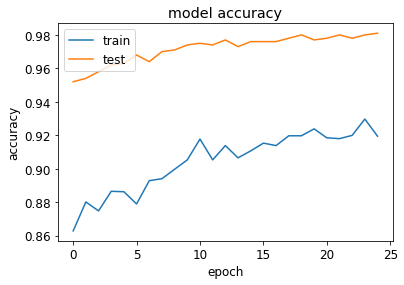

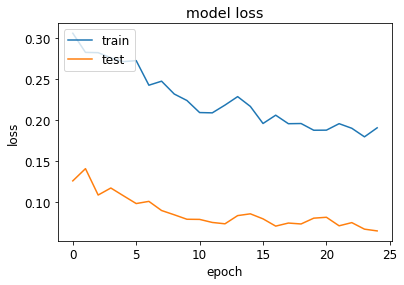

In [96]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
model.save(cnn_outputs + 'seti_inc3_binary_20190130_v1.h5')
model.save_weights(cnn_outputs + 'seti_weights_inc3_binary_20190130_v1.h5')

## Predict on the test set

In [97]:
predictions = model.predict_generator(test_generator, steps = test_size, verbose = 1)

1000/1000 [==============================] - 60s 60ms/step


In [98]:
df = pd.DataFrame(predictions)
df['filename'] = test_generator.filenames

In [99]:
df['truth'] = ''
df['truth'] = df['filename'].str.split('/', 1, expand = True)
df['prediction_index'] = df[[0,1]].idxmax(axis=1)

In [100]:
df['prediction'] = ''
df['prediction'][df['prediction_index'] == 0] = 'neg'
df['prediction'][df['prediction_index'] == 1] = 'pos'

confusion_matrix = metrics.confusion_matrix(df['truth'], df['prediction'])

In [101]:
total=sum(sum(confusion_matrix))

sensitivity = float(confusion_matrix[0,0])/float(confusion_matrix[0,0]+confusion_matrix[0,1])
print('Sensitivity : ', sensitivity)

specificity = float(confusion_matrix[1,1])/float(confusion_matrix[1,0]+confusion_matrix[1,1])
print('Specificity : ', specificity)

('Sensitivity : ', 0.99)
('Specificity : ', 0.96)


In [102]:
df['truth_bin'] = 0
df['truth_bin'][df['truth'] == 'pos'] = 1

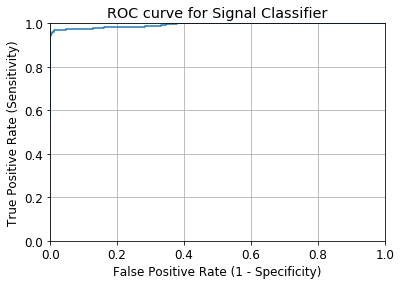

In [103]:
fpr, tpr, thresholds = metrics.roc_curve(df['truth_bin'], df[1])

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Signal Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

### Prediction on Open Data

In [104]:
path = '/home/paperspace/Documents/SETI/abacad/'
cnn_outputs = path + 'cnn_outputs/'

#model = load_model(cnn_outputs + 'seti_inc3_binary_20190130_v1.h5')
#model.load_weights(cnn_outputs + 'seti_weights_inc3_binary_20190130_v1.h5')

#open data inputs
open_data = '/home/paperspace/Documents/SETI/abacad/open/'

In [105]:
img_dim  = 197
open_data_files = os.listdir(open_data)
len(open_data_files)

13

In [106]:
def image_preprocess(file):
    img = image.load_img(file, target_size=[img_dim,img_dim])
    img = image.img_to_array(img)
    img = img.reshape(1, img_dim, img_dim, 3)
    return(img)

In [107]:
threshold = 0.75

Candidate_waterfall_plots.samesig.png
[[0.6954276 0.3045724]]
Signal? ... False


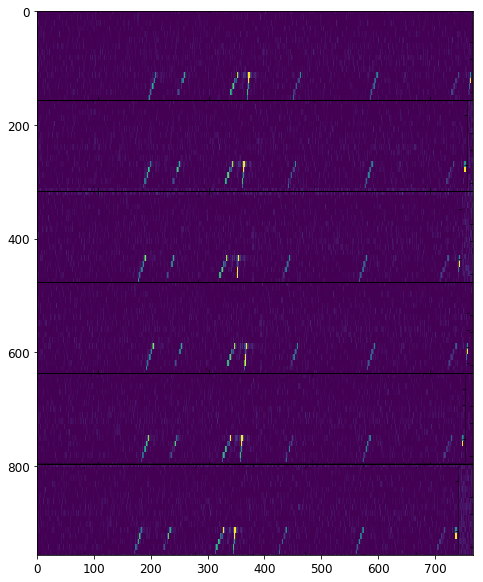

In [108]:
file_choice = open_data_files[0]

img = image_preprocess(open_data + file_choice)

print(file_choice)
pred = model.predict(img)
print(pred)
print("Signal? ... " + str(pred[0][1] > threshold))

fig = plt.figure(figsize=(10, 10))
plt.imshow(Image.open(open_data + file_choice))
plt.show()

Candidate_waterfall_plots.HIP17147.png
[[0.09922497 0.900775  ]]
Signal? ... True


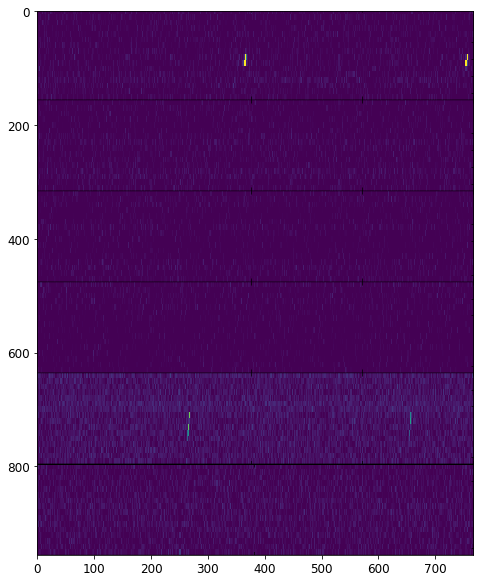

In [77]:
file_choice = open_data_files[1]

img = image_preprocess(open_data + file_choice)

print(file_choice)
pred = model.predict(img)
print(pred)
print("Signal? ... " + str(pred[0][1] > threshold))

fig = plt.figure(figsize=(10, 10))
plt.imshow(Image.open(open_data + file_choice))
plt.show()

Candidate_waterfall_plots.HIP17147.png
[[0.15742001 0.84257996]]
Signal? ... True


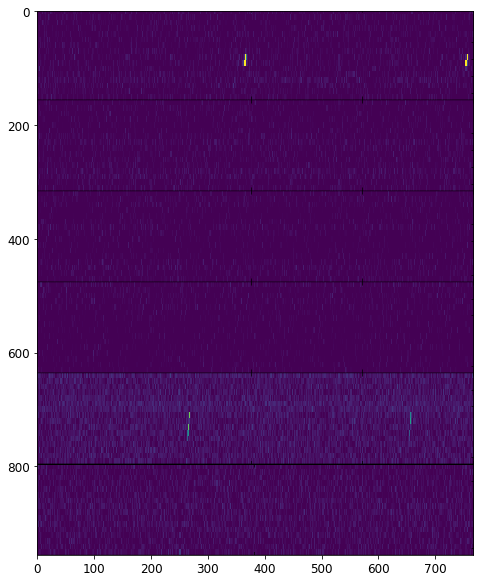

In [109]:
file_choice = open_data_files[2]

img = image_preprocess(open_data + file_choice)

print(file_choice)
pred = model.predict(img)
print(pred)
print("Signal? ... " + str(pred[0][1] > threshold))

fig = plt.figure(figsize=(10, 10))
plt.imshow(Image.open(open_data + file_choice))
plt.show()

Candidate_waterfall_plots.HIP39826.png
[[0.7671347 0.2328653]]
Signal? ... False


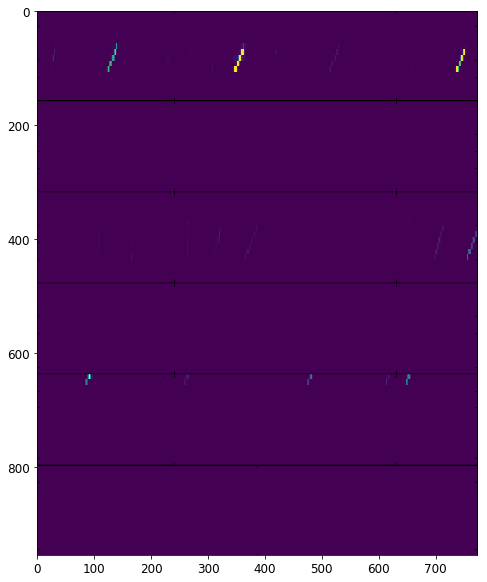

In [110]:
file_choice = open_data_files[3]

img = image_preprocess(open_data + file_choice)

print(file_choice)
pred = model.predict(img)
print(pred)
print("Signal? ... " + str(pred[0][1] > threshold))

fig = plt.figure(figsize=(10, 10))
plt.imshow(Image.open(open_data + file_choice))
plt.show()

Candidate_waterfall_plots.HIP99427.png
[[0.09811989 0.90188015]]
Signal? ... True


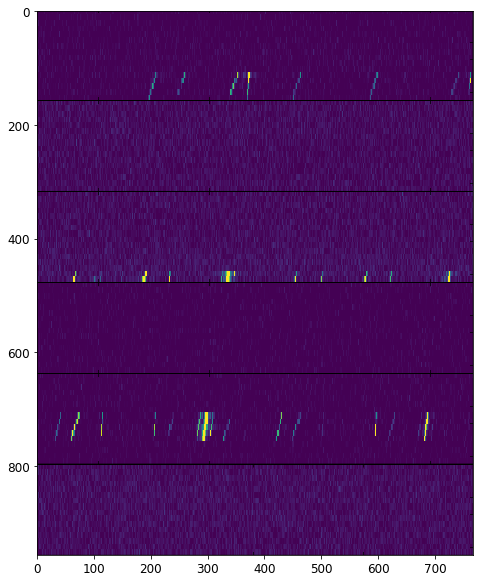

In [111]:
file_choice = open_data_files[4]

img = image_preprocess(open_data + file_choice)

print(file_choice)
pred = model.predict(img)
print(pred)
print("Signal? ... " + str(pred[0][1] > threshold))

fig = plt.figure(figsize=(10, 10))
plt.imshow(Image.open(open_data + file_choice))
plt.show()

Candidate_waterfall_plots.HIP66704.png
[[0.5088137  0.49118632]]
Signal? ... False


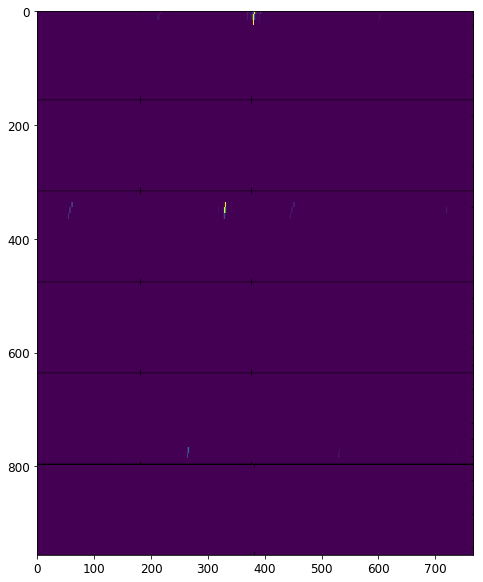

In [112]:
file_choice = open_data_files[5]

img = image_preprocess(open_data + file_choice)

print(file_choice)
pred = model.predict(img)
print(pred)
print("Signal? ... " + str(pred[0][1] > threshold))

fig = plt.figure(figsize=(10, 10))
plt.imshow(Image.open(open_data + file_choice))
plt.show()

Candidate_waterfall_plots.HIP74981.png
[[0.23868516 0.76131487]]
Signal? ... True


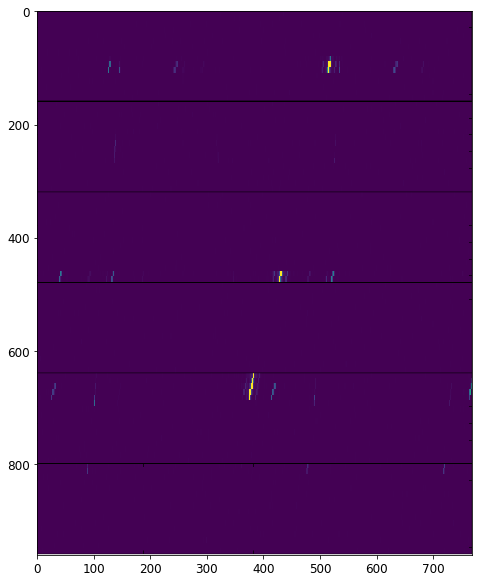

In [113]:
file_choice = open_data_files[6]

img = image_preprocess(open_data + file_choice)

print(file_choice)
pred = model.predict(img)
print(pred)
print("Signal? ... " + str(pred[0][1] > threshold))

fig = plt.figure(figsize=(10, 10))
plt.imshow(Image.open(open_data + file_choice))
plt.show()

Candidate_waterfall_plots.HIP45493.png
[[0.58114105 0.41885895]]
Signal? ... False


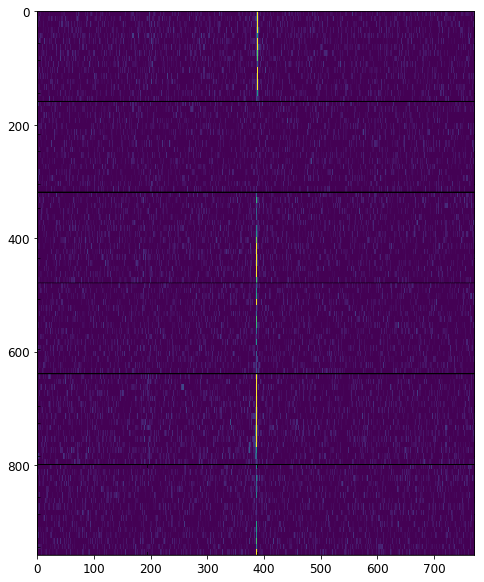

In [114]:
file_choice = open_data_files[7]

img = image_preprocess(open_data + file_choice)

print(file_choice)
pred = model.predict(img)
print(pred)
print("Signal? ... " + str(pred[0][1] > threshold))

fig = plt.figure(figsize=(10, 10))
plt.imshow(Image.open(open_data + file_choice))
plt.show()

Candidate_waterfall_plots.HIP82860.png
[[0.33122233 0.66877764]]
Signal? ... False


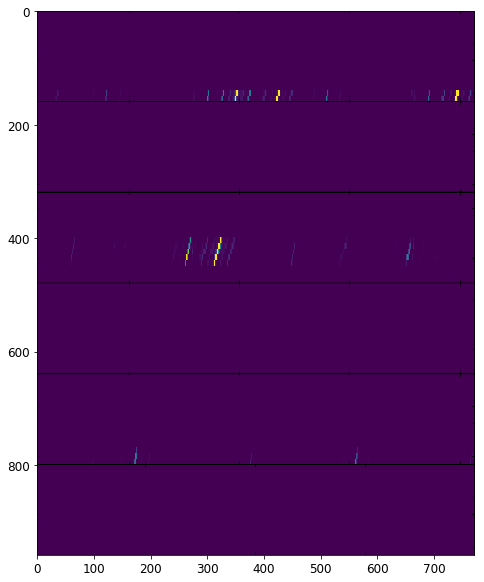

In [115]:
file_choice = open_data_files[8]

img = image_preprocess(open_data + file_choice)

print(file_choice)
pred = model.predict(img)
print(pred)
print("Signal? ... " + str(pred[0][1] > threshold))

fig = plt.figure(figsize=(10, 10))
plt.imshow(Image.open(open_data + file_choice))
plt.show()

Candidate_waterfall_plots.HIP65352.png
[[0.23615457 0.76384544]]
Signal? ... True


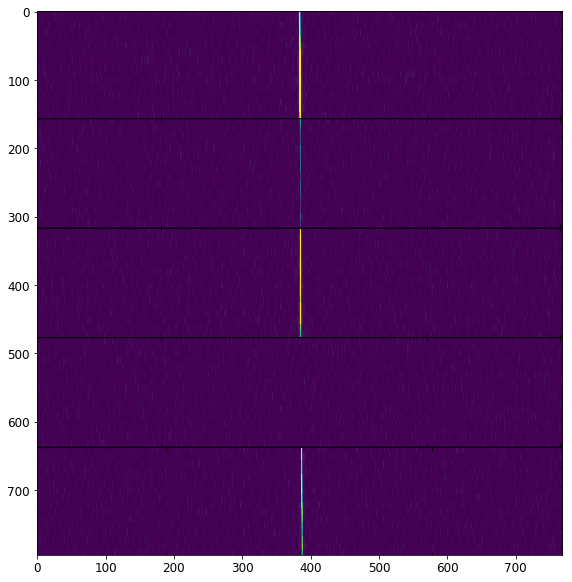

In [116]:
file_choice = open_data_files[9]

img = image_preprocess(open_data + file_choice)

print(file_choice)
pred = model.predict(img)
print(pred)
print("Signal? ... " + str(pred[0][1] > threshold))

fig = plt.figure(figsize=(10, 10))
plt.imshow(Image.open(open_data + file_choice))
plt.show()

Candidate_waterfall_plots.HIP4436.png
[[0.0822396 0.9177604]]
Signal? ... True


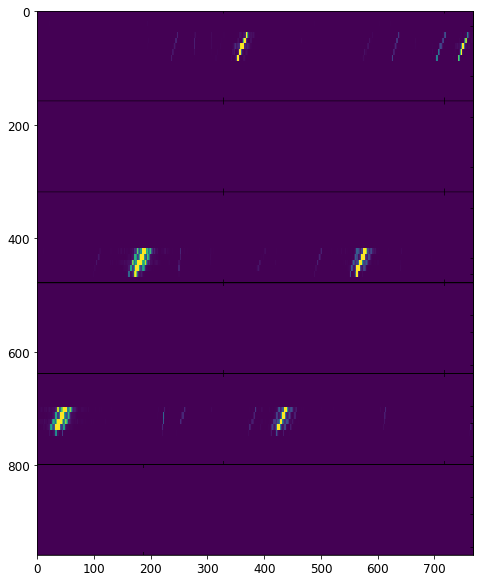

In [88]:
file_choice = open_data_files[10]

img = image_preprocess(open_data + file_choice)

print(file_choice)
pred = model.predict(img)
print(pred)
print("Signal? ... " + str(pred[0][1] > threshold))

fig = plt.figure(figsize=(10, 10))
plt.imshow(Image.open(open_data + file_choice))
plt.show()

Candidate_waterfall_plots.HIP4436.png
[[0.06636567 0.9336343 ]]
Signal? ... True


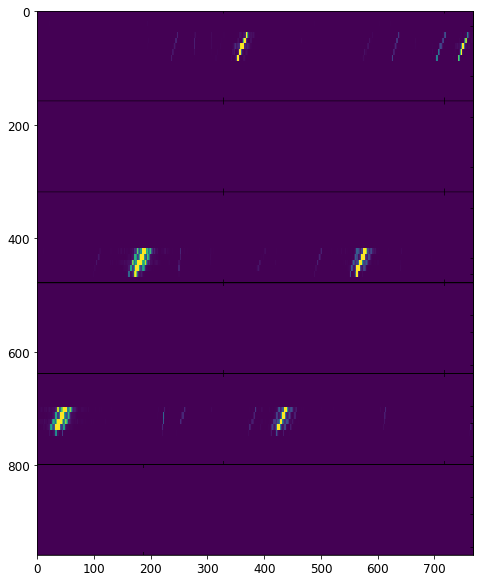

In [117]:
file_choice = open_data_files[11]

img = image_preprocess(open_data + file_choice)

print(file_choice)
pred = model.predict(img)
print(pred)
print("Signal? ... " + str(pred[0][1] > threshold))

fig = plt.figure(figsize=(10, 10))
plt.imshow(Image.open(open_data + file_choice))
plt.show()

Candidate_waterfall_plots.HIP7981.png
[[0.27177244 0.7282276 ]]
Signal? ... False


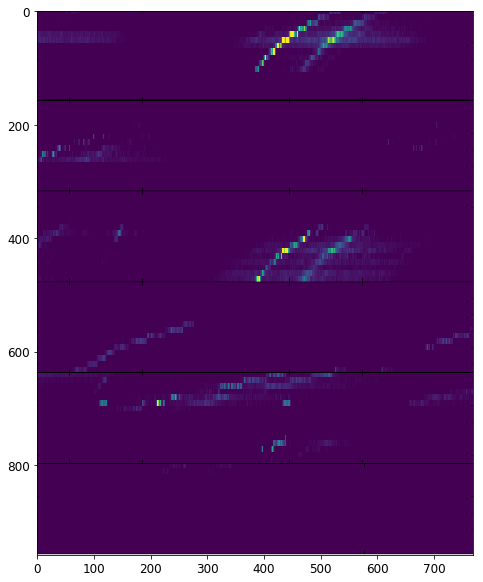

In [118]:
file_choice = open_data_files[12]

img = image_preprocess(open_data + file_choice)

print(file_choice)
pred = model.predict(img)
print(pred)
print("Signal? ... " + str(pred[0][1] > threshold))

fig = plt.figure(figsize=(10, 10))
plt.imshow(Image.open(open_data + file_choice))
plt.show()